In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score, recall_score
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

2025-05-02 01:40:40.869710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 01:40:40.869823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 01:40:40.879406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 01:40:40.913659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 01:40:42.046255: W tensorflow/compiler/tf2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

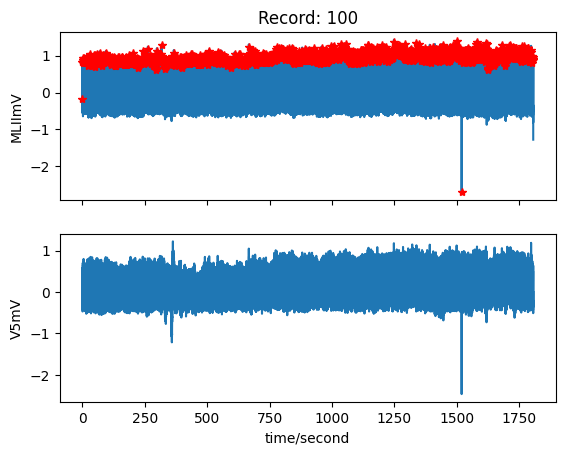

In [3]:
record = wfdb.rdrecord('100', pn_dir='mitdb')
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')
wfdb.plot_wfdb(record=record, annotation=annotation)

In [4]:
signal = record.p_signal[:,0] # Using only the first channel
peaks = annotation.sample  
labels = annotation.symbol 
print(np.unique(labels))

window_before = 100
window_after = 100
segments = []
segment_labels = []

for i, r in enumerate(peaks):
    if r - window_before >= 0 and r + window_after < len(signal):
        beat = signal[r - window_before : r + window_after]
        segments.append(beat)
        segment_labels.append(labels[i])


valid_symbols = {'N', 'A'}
filtered_segments = []
filtered_labels = []

for seg, lab in zip(segments, segment_labels):
    if lab in valid_symbols:
        filtered_segments.append(seg)
        filtered_labels.append(lab)

X = np.array(filtered_segments).reshape(-1, 200, 1)
y = np.array(filtered_labels)

# N_elements_X = X[y=='N'].copy()
# N_elements_target = y[y=='N'].copy()

# random_choiche = [True]*50 + [False]*(len(N_elements_X)-50)
# np.random.shuffle(random_choiche)

# chosen_N = N_elements_X[random_choiche].copy()
# chosen_N_Target = N_elements_target[random_choiche].copy()

# len(chosen_N)

# A_elements_X = X[y=='A'].copy()
# A_elements_target = y[y=='A'].copy()
# X = np.concatenate([chosen_N, A_elements_X])
# y = np.concatenate([chosen_N_Target, A_elements_target])


label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
one_hot_labels = to_categorical(integer_encoded)


['+' 'A' 'N' 'V']


In [5]:
np.unique(y)

array(['A', 'N'], dtype='<U1')

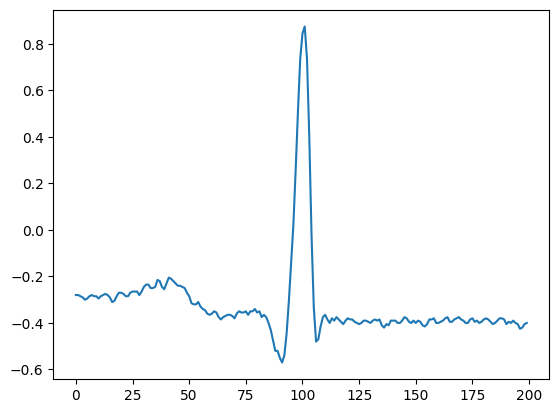

In [6]:
plt.plot(X[6])

In [7]:
class ECGCNN(nn.Module):
    def __init__(self, input_length):
        super(ECGCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        conv_output_length = input_length // 4  
        

        self.fc1 = nn.Linear(64 * conv_output_length, 128) 
        self.fc2 = nn.Linear(128, 2) 

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, 1, input_length)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [8]:
class ECGLSTM(nn.Module):
    def __init__(self, input_length):
        super(ECGLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)        

        self.fc1 = nn.Linear(input_length * 128, 64)
        self.fc2 = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x: (batch, 1, L) → (batch, L, 1)
        x = x.permute(0, 2, 1)
        
        # LSTM
        out, (hn, cn) = self.lstm(x)
        out = out.contiguous().view(out.size(0), -1)
        
        # Dense layers
        x = F.relu(self.fc1(out))
        x = self.sigmoid(self.fc2(x)) # logits
        return x

In [12]:
class ECGHYBRID(nn.Module):
    def __init__(self, input_length):
        super(ECGHYBRID, self).__init__()
        
        self.input_length = input_length
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        

        self.fc1 = nn.Linear(50*128, 64)
        self.fc2 = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        # x: (batch, 1, L) → (batch, L, 1)
        x = x.permute(0, 2, 1)
        
        # LSTM
        out, (hn, cn) = self.lstm(x)
        out = out.contiguous().view(out.size(0), -1)
        
        # Dense layers
        x = F.relu(self.fc1(out))
        x = self.sigmoid(self.fc2(x)) # logits
        return x

# Training

In [13]:
# Reshape X per PyTorch CNN1D: (N, 1, L)
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X = X.reshape(X.shape[0], 1, X.shape[1])



# Dividi in train/test
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_labels, test_size=0.3, random_state=42, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to("cuda")
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to("cuda")
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

ValueError: cannot reshape array of size 454000 into shape (2270,1,1)

In [20]:
model = ECGLSTM(input_length=200)

def training(model, _x, _y, n_epochs = 50, device = "cuda"):
    # Converti in tensori
    X_train_tensor = torch.tensor(_x, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(_y, dtype=torch.long).to(device)

    # Crea DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    cw = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(_y[:,0]), y=_y[:,0])
    print(cw)
    sample_weight = (((_y[:,0] == 1) * 200 ) + ((_y[:,0] == 0) * 1))
    sample_weight = torch.tensor(sample_weight).to(device)


    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            weighted_loss = loss * sample_weight 
            loss = weighted_loss.mean()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)

        avg_loss = running_loss / total    
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")

training(model, X_train, y_train, n_epochs = 100)

[ 0.50766773 33.10416667]
Epoch 1: Loss=0.5052
Epoch 2: Loss=0.3321
Epoch 3: Loss=0.3150
Epoch 4: Loss=0.3258
Epoch 5: Loss=0.3214
Epoch 6: Loss=0.3556
Epoch 7: Loss=0.3229
Epoch 8: Loss=0.3173
Epoch 9: Loss=0.3136
Epoch 10: Loss=0.3110
Epoch 11: Loss=0.3061
Epoch 12: Loss=0.2985
Epoch 13: Loss=0.2749
Epoch 14: Loss=0.2613
Epoch 15: Loss=0.2019
Epoch 16: Loss=0.1621
Epoch 17: Loss=0.2024
Epoch 18: Loss=0.1433
Epoch 19: Loss=0.1417
Epoch 20: Loss=0.1272
Epoch 21: Loss=0.1427
Epoch 22: Loss=0.1258
Epoch 23: Loss=0.1154
Epoch 24: Loss=0.1059
Epoch 25: Loss=0.1180
Epoch 26: Loss=0.1056
Epoch 27: Loss=0.0947
Epoch 28: Loss=0.1004
Epoch 29: Loss=0.1061
Epoch 30: Loss=0.0957
Epoch 31: Loss=0.1001
Epoch 32: Loss=0.1147
Epoch 33: Loss=0.0822
Epoch 34: Loss=0.0810
Epoch 35: Loss=0.0791
Epoch 36: Loss=0.0787
Epoch 37: Loss=0.0720
Epoch 38: Loss=0.0717
Epoch 39: Loss=0.0803
Epoch 40: Loss=0.0781
Epoch 41: Loss=0.0655
Epoch 42: Loss=0.0697
Epoch 43: Loss=0.0603
Epoch 44: Loss=0.0704
Epoch 45: Loss=

In [21]:
test_output = model(X_test_tensor).to("cpu")

print("Balanced accuracy:", balanced_accuracy_score(y_test[:,0], test_output[:,0] > 0.5))
print("N elements accuracy:", recall_score(y_test[:,0] == 0, test_output[:,0] <= 0.5)) 
print("A elements accuracy:", recall_score(y_test[:,0], test_output[:,0] > 0.5)) 

Balanced accuracy: 0.8325892857142857
N elements accuracy: 0.9985119047619048
A elements accuracy: 0.6666666666666666
